In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import pickle

import dash
import dash_core_components as dcc
import dash_html_components as html

import plotly.express as px


Bad key "text.kerning_factor" on line 4 in
/Users/johnlee/opt/anaconda3/envs/metis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [18]:
# read in actual ride counts and predictions from fb prophet model
citibike_df = pd.read_pickle('citibike_df_preprocessed.pkl')
#citibike_forecast = pd.read_pickle('forecasts.pkl')
citibike_pred_all = pd.read_pickle('citibike_pred_all.pkl')

In [19]:
# load in latest station latitude and longitude
stations_df = pd.read_csv('201912-citibike-tripdata.csv') 

stations_df = stations_df.sort_values('starttime', ascending=True) 

stations_df_group = stations_df.groupby(['start station id', 'start station name', 
                                         'start station latitude', 'start station longitude']).first().reset_index()

stations_df_group = stations_df_group[['start station id', 'start station name', 
                                       'start station latitude', 'start station longitude']]

stations_list = [i for i in stations_df_group['start station id'].unique() if i in citibike_pred_all.station_id.unique()]

stations_df_group = stations_df_group[stations_df_group['start station id'].isin(stations_list)]

stations_df_group = stations_df_group.drop_duplicates('start station id', keep='first')

stations_df_group

,start station id,start station name,start station latitude,start station longitude
1,79,Franklin St & W Broadway,40.719116,-74.006667
5,119,Park Ave & St Edwards St,40.696089,-73.978034
6,120,Lexington Ave & Classon Ave,40.686768,-73.959282
7,127,Barrow St & Hudson St,40.731724,-74.006744
8,128,MacDougal St & Prince St,40.727103,-74.002971
...,...,...,...,...
305,2008,Little West St & 1 Pl,40.705693,-74.016777
306,2009,Catherine St & Monroe St,40.711174,-73.996826
307,2012,E 27 St & 1 Ave,40.739445,-73.976806
309,2021,W 45 St & 8 Ave,40.759291,-73.988597


In [20]:
# merge citibike df with citibike pred all
plot_df = pd.merge(citibike_df, citibike_pred_all, how='left', 
                   left_on=['date','station_id'], right_on=['date','station_id'])

plot_df = plot_df.drop(['mean_duration', 'ride_counts', 'ride_counts_clean_y', 'replace_zeroes',
                        'error', 'error_abs', 'error_sq', 'station_latitude', 'station_longitude'], axis=1)

plot_df.columns = ['date', 'station_id', 'station_name', #'station_latitude', 'station_longitude',
                   'year', 'month', 'day_of_week', 'y_actual', 'y_pred']

plot_df.head()

,date,station_id,station_name,year,month,day_of_week,y_actual,y_pred
0,2015-01-01,79,Franklin St & W Broadway,2015,1,3,15,NaN
1,2015-01-02,79,Franklin St & W Broadway,2015,1,4,22,NaN
2,2015-01-03,79,Franklin St & W Broadway,2015,1,5,15,NaN
3,2015-01-04,79,Franklin St & W Broadway,2015,1,6,27,NaN
4,2015-01-05,79,Franklin St & W Broadway,2015,1,0,27,NaN


In [21]:
# merge latest station latitude and longitude info
plot_df = pd.merge(plot_df, stations_df_group[['start station id', 
                                              'start station latitude', 
                                              'start station longitude']], how='left', 
                   left_on='station_id', right_on='start station id')

plot_df = plot_df.drop(['start station id'], axis=1)

plot_df.columns = ['date', 'station_id', 'station_name', 
                   'year', 'month', 'day_of_week', 'y_actual', 'y_pred',
                   'station_latitude', 'station_longitude']

plot_df = plot_df[['date', 'station_id', 'station_name', 'station_latitude', 'station_longitude',
            'year', 'month', 'day_of_week', 'y_actual', 'y_pred']]

plot_df.head()

,date,station_id,station_name,station_latitude,station_longitude,year,month,day_of_week,y_actual,y_pred
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,3,15,NaN
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,4,22,NaN
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,5,15,NaN
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,6,27,NaN
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,0,27,NaN


In [22]:
plot_df.head()

,date,station_id,station_name,station_latitude,station_longitude,year,month,day_of_week,y_actual,y_pred
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,3,15,NaN
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,4,22,NaN
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,5,15,NaN
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,6,27,NaN
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,0,27,NaN


In [177]:
# check version of dash
print(dcc.__version__)

1.10.0


/Users/johnlee/opt/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



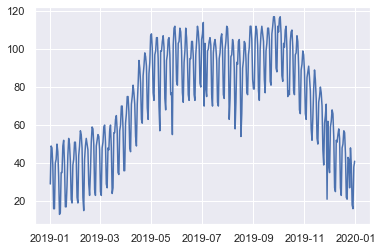

In [179]:
plt.plot(plot_df[(plot_df.station_id == 79) & 
                 (plot_df.year == 2019)].date, 
         plot_df[(plot_df.station_id == 79) &
                 (plot_df.year == 2019)].y_pred);

In [97]:
plot_df[plot_df.station_id == 491]

,date,station_id,station_name,station_latitude,station_longitude,year,month,day_of_week,y_actual,y_pred
279378,2015-01-01,491,E 24 St & Park Ave S,40.74,-73.986,2015,1,3,8,NaN
279379,2015-01-02,491,E 24 St & Park Ave S,40.74,-73.986,2015,1,4,52,NaN
279380,2015-01-03,491,E 24 St & Park Ave S,40.74,-73.986,2015,1,5,13,NaN
279381,2015-01-04,491,E 24 St & Park Ave S,40.74,-73.986,2015,1,6,26,NaN
279382,2015-01-05,491,E 24 St & Park Ave S,40.74,-73.986,2015,1,0,93,NaN
...,...,...,...,...,...,...,...,...,...,...
281199,2019-12-27,491,E 24 St & Park Ave S,40.74,-73.986,2019,12,4,115,224.0
281200,2019-12-28,491,E 24 St & Park Ave S,40.74,-73.986,2019,12,5,46,26.0
281201,2019-12-29,491,E 24 St & Park Ave S,40.74,-73.986,2019,12,6,45,33.0
281202,2019-12-30,491,E 24 St & Park Ave S,40.74,-73.986,2019,12,0,49,255.0


In [149]:
# create new column that 'melts' y actual and y pred (for multi-colored lines on plotly express)
plot_df['pred_vs_actual'] = np.where(plot_df.y_pred.isnull(), 'actual', 'pred')
plot_df['y'] = np.where(plot_df.pred_vs_actual == 'actual', plot_df.y_actual, plot_df.y_pred)
plot_df.y = plot_df.y.astype(int)
plot_df

,date,station_id,station_name,station_latitude,station_longitude,year,month,day_of_week,y_actual,y_pred,pred_vs_actual,y
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,3,15,NaN,actual,15
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,4,22,NaN,actual,22
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,5,15,NaN,actual,15
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,6,27,NaN,actual,27
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,0,27,NaN,actual,27
...,...,...,...,...,...,...,...,...,...,...,...,...
332327,2019-12-27,2022,E 59 St & Sutton Pl,40.759107,-73.959223,2019,12,4,26,22.0,pred,22
332328,2019-12-28,2022,E 59 St & Sutton Pl,40.759107,-73.959223,2019,12,5,39,12.0,pred,12
332329,2019-12-29,2022,E 59 St & Sutton Pl,40.759107,-73.959223,2019,12,6,10,15.0,pred,15
332330,2019-12-30,2022,E 59 St & Sutton Pl,40.759107,-73.959223,2019,12,0,4,24.0,pred,24


In [157]:
# plot time series using plotly express
fig = px.line(plot_df[(plot_df.year > 2014) & 
                      (plot_df.station_id == 491)], 
              x='date', y='y', 
              color='pred_vs_actual', 
              color_discrete_sequence=['blue','orange'],
              line_dash='pred_vs_actual',
              line_dash_sequence=['solid', 'dot'],
              title='Forecasted demand for station in 2019',
              height=500)

fig.update_layout(showlegend=False, xaxis_title='Date',yaxis_title='# of Rides')

fig.show()

In [150]:
# pickle plot df
#plot_df.to_pickle('citibike_plot_df.pkl')
plot_df = pd.read_pickle('citibike_plot_df.pkl')

In [51]:
plot_df.head()

,date,station_id,station_name,station_latitude,station_longitude,year,month,day_of_week,y_actual,y_pred
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,3,15,NaN
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,4,22,NaN
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,5,15,NaN
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,6,27,NaN
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,2015,1,0,27,NaN


In [158]:
# group by stations for map plot
plot_df_group = plot_df.groupby(['station_name']).first().reset_index()

In [159]:
plot_df_group

,station_name,date,station_id,station_latitude,station_longitude,year,month,day_of_week,y_actual,y_pred,pred_vs_actual,y
0,1 Ave & E 15 St,2015-01-01,504,40.731000,-73.983000,2015,1,3,52,72.0,actual,52
1,1 Ave & E 30 St,2015-01-01,536,40.741444,-73.975361,2015,1,3,26,55.0,actual,26
2,1 Ave & E 44 St,2015-01-01,455,40.750020,-73.969053,2015,1,3,5,45.0,actual,5
3,11 Ave & W 27 St,2015-01-01,458,40.751396,-74.005226,2015,1,3,11,52.0,actual,11
4,11 Ave & W 41 St,2015-01-01,478,40.760301,-73.998842,2015,1,3,26,42.0,actual,26
...,...,...,...,...,...,...,...,...,...,...,...,...
177,West Thames St,2015-01-01,363,40.708347,-74.017134,2015,1,3,16,32.0,actual,16
178,William St & Pine St,2015-01-01,360,40.707179,-74.008873,2015,1,3,6,28.0,actual,6
179,Willoughby Ave & Hall St,2015-01-01,244,40.691960,-73.965369,2015,1,3,9,28.0,actual,9
180,Willoughby Ave & Walworth St,2015-01-01,373,40.693317,-73.953820,2015,1,3,6,5.0,actual,6


In [170]:
# plot stations on a map via scatter mapbox
fig = px.scatter_mapbox(plot_df_group,
                        lat=plot_df_group['station_latitude'], 
                        lon=plot_df_group['station_longitude'],
                        title='Citi Bike stations in NYC:',
                        zoom=11.6, 
                        width=550, 
                        height=750,
                        hover_name='station_name',
                        #hover_data={'station_latitude': False, 'station_longitude': False},
                        center={'lat': 40.72642, 'lon': -73.990},
                        labels={'station_latitude': 'latitude',
                                'station_longitude': 'longitude'}) 

fig.update_layout(mapbox_style='carto-positron') #, hovermode=

fig.show()